In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import timeit
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.integrate as Nint
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline

from joblib import Parallel, delayed
mpl.rcParams['text.usetex'] = True

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

## In the RDU, extremely small modes that re-enter the horizon in the gradient instability phase my exhibit amplification. This phase spans the following time interval following the end of inflation:

## $$ y_{\rm end} \leq y \leq y_{\rm c}$$
## where
## $$y_{\rm c} = \sqrt{\alpha_{\rm I}}\, y_{\rm end},\quad\quad y_{\rm end} =  \frac{a_{\rm end}}{a_*} = \sqrt{\frac{m}{H_{\rm I}}},\quad \textrm{and}\quad \alpha_{\rm I} = \alpha \frac{H_{\rm I}}{m}$$
## Recall that we are typically interested in the following parameter space $m/H_{\rm I}\ll \alpha \ll 1$ such that $\alpha_{\rm I}\gg 1$


In [17]:
# Define lists of parameters to be picked from 

asq_I = [10 ** 3, 10 ** 4, 10 ** 5, 10 ** 6]

m = [10**(-15),10**(-20),10**(-25),10**(-30),10**(-35)]# an array of bare mass choices in units of H_I
y_end = [mass ** (1/2) for mass in m] # End of inflation for a given mass 
x_rh = [mass ** (-1/2) for mass in m] # the scale that exit the horizon at the end of inflation

# Set some indexes to choose which parameters we focus at a given time 

a_ind1 = 0;
y_ind1 = 0; # this is also the index of mass m

a_ind2 = 1;
y_ind2 = 1; # this is also the index of mass m

y_c1 = (asq_I[a_ind1] ** (1/4)) * y_end[y_ind1]

x_c1 = y_c1 ** (-1) # the scale that re-enters the horizon when 'G' phase ends 

y_c2 = (asq_I[a_ind2] ** (1/4)) * y_end[y_ind2]

x_c2 = y_c2 ** (-1) # the scale that re-enters the horizon when 'G' phase ends 

## For each mode horizon re-entery time is marked by $x_* = y_{\rm re}^{-1}$ so that the mode that re-enter the horizon at the end of the gradient instablity phase is given by

## $$ x^{\rm c}_* = y_{c}^{-1}$$
## To study the dynamics, we therefore first generate a grid of scales within the following range: 
## $$ x^{\rm c}_* < x_* < x^{\rm rh}_*$$
## where $x^{\rm rh}_*$ denotes the modes that re-enters the horizon at the end of inflation

In [18]:
# Generate a list of potentially unstable modes that re-enter the horizon during the 'G' phase
xi1 = x_c1  
xf1 = x_rh[y_ind1]

xi2 = x_c2  
xf2 = x_rh[y_ind2]

xnum = 15

xs1 = []
xs2 = []
for i in np.arange(1,16):
    xs1.append(xi1*(xf1/xi1)**((i-1)/(xnum-1)))
    xs2.append(xi2*(xf2/xi2)**((i-1)/(xnum-1))) 

## We work with 
## $$ x_{\rm *} \equiv \frac{k}{k_{*}}, \quad y \equiv \frac{a}{a_{*}}, \quad \alpha_I \equiv \alpha \frac{H_{\rm I}}{m}$$
## to study dynamics of individual longitudinal modes (labeled by $x_*$) during inflation using $y$ as the independent variable:
## $$A''_L(y) + \frac{2 x_*^2 + y^2 (1 + \alpha_{\rm I}^2)}{x_*^2 + y^2 (1 + \alpha_{\rm I}^2)}\frac{2}{y} A_L'(y) + \left[\frac{x_*^2\, y_{\rm end}^4}{y^4}+\frac{y_{\rm end}^4\,(1 + \alpha_{\rm I}^2)}{y^2}\right]A_L(y) = 0 $$ where $A_L$ is assumed to be given in units of 
## $$A^{(0)}_L(k) = \frac{1}{\sqrt{2k}}\frac{H_{\rm I}}{m_{\rm eff,I}},\quad\quad m_{\rm eff,I}^2 = m^2 + \alpha^2 H_{\rm I}^2$$
## For light vector field during inflation, all modes are relativistic at the horizon exit and so we can initialize the modes using 
## $$ A_L(y) = \left(1 - \frac{i x_* y_{\rm end}^2}{y}\right)\, {\rm e}^{i x_*\, y_{\rm end}^2/y}, \quad\quad A_L'(y) = -\frac{x_*^2\, y_{\rm end}^4}{y^3}\,{\rm e}^{i x_*\, y_{\rm end}^2/y} $$
## where the end of inflation and the time of mode initilization are given in terms of $y$ as 
## $$ y_{\rm end} = \frac{a_{\rm end}}{a_*} = \sqrt{\frac{m}{H_{\rm I}}}, \quad\quad y_{\rm in} = x_*\, y_{\rm end}^2$$
## We solve the equation above for extremely small scale modes $x^{\rm rh}_* > x_* > x^{\rm c}_*$ for the time range specified above $y_{\rm end}\leq y \leq y_{\rm c}$ 

In [19]:
# Generate initial conditions by solving the evolution of A_L on the inflation side

def eomINFAL(t,v,k,asq,ye):
    
    AL = v[0]
    ALp = v[1]
    
    vdot = [[],[]]
    
    vdot[0] = ALp
    vdot[1] = -(2 * (2*k**2 + t**2 * (1 + asq)) * ALp)/(t*(k**2 + t**2 * (1 + asq))) - (k**2 * ((ye/t)**4) + (ye**4) * (1 + asq)/t**2)*AL
    return vdot

In [20]:
# Define tasks for parallel processing, not really necessary as we are iterating over a small number of scales
# but it could be useful for later use

# Notice that we solve for each x_* and return the last element in the solutions corresponding to the value of 
# A_L and A_L' at the end of inflation

def process1(i):
    
    sol = solve_ivp(lambda t,v: eomINFAL(t,v,xs1[i],asq_I[a_ind1],y_end[y_ind1]),(xs1[i] * y_end[y_ind1]**2, y_end[y_ind1]), [(1. - 1.j) * np.exp(1.j), - ((xs1[i] * y_end[y_ind1]**2)**(-1)) * np.exp(1.j)], rtol = 1e-10, atol = 1e-20)   
    
    return [sol.y[0][len(sol.y[0])-1],sol.y[1][len(sol.y[1])-1]]

def process2(i):
    
    sol = solve_ivp(lambda t,v: eomINFAL(t,v,xs2[i],asq_I[a_ind2],y_end[y_ind2]),(xs2[i] * y_end[y_ind2]**2, y_end[y_ind2]), [(1. - 1.j) * np.exp(1.j), - ((xs2[i] * y_end[y_ind2]**2)**(-1)) * np.exp(1.j)], rtol = 1e-10, atol = 1e-20)   
    
    return [sol.y[0][len(sol.y[0])-1],sol.y[1][len(sol.y[1])-1]]

In [21]:
start = timeit.default_timer()


fc1 = [] # Final Conditions list containing a list of tuples
         # (A_L, A_L') evaluated at the end of inflation and corresponding to different x_* we picked
fc2 = []

fc1.append(Parallel(n_jobs=4)(delayed(process1)(i) for i in range(len(xs1))))
fc2.append(Parallel(n_jobs=4)(delayed(process2)(i) for i in range(len(xs2))))

stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  0.9285697419995813


In [22]:
xsindex = 13 # pick next to the final mode that is slightly larger than k_rh

yre1 = xs1[xsindex] ** (-1) # horizon re-entry of this very short mode
yre2 = xs2[xsindex] ** (-1) # horizon re-entry of this very short mode

## Using the final conditions above we can compute the evolution of $A_L$ in RDU by numerically solving:
### $$A''_L(y) + \left[\frac{1-\alpha^2(y)}{1+\alpha^2(y)}\right]\left(1 + \frac{y^2}{x_*^2}(1 + \alpha^2(y))\right)^{-1}\frac{2}{y} A_L'(y) + \frac{3-\alpha^2(y)}{3(1 + \alpha^2(y))}\left[{x_*^2}+y^2(1 + \alpha^2(y))\right]A_L(y) = 0 $$
## where
## $$ \alpha(y) = \alpha_{I} \left(\frac{y_{\rm end}}{y}\right)^2$$
## In particular, we will compute mode evaluation between $y_{\rm end}\leq y \leq y_{\rm c}{\rm e}^{5/2}$, i.e untial 2.5 e-folds after the end of the gradient instability phase

In [23]:
# Use these final conditions to evolve these modes during RDU

def eomRDUAL(t,v,k,asq,ye):
    
    AL = v[0]
    ALp = v[1]
    
    vdot = [[],[]]
    
    vdot[0] = ALp
    vdot[1] = -2 * (1 - asq * (ye ** 4 / t ** 4)) * (k**2 * ALp)/((1 + asq * (ye ** 4 / t ** 4)) * t * (k**2 + t**2 * (1 + asq * (ye ** 4 / t ** 4)))) - (3 - asq * (ye ** 4 / t ** 4))*(k**2 + t**2 * (1 +  asq * (ye ** 4 / t ** 4)))*AL/(3 * (1 + asq * (ye ** 4 / t ** 4)))
    return vdot

In [40]:
# Two solution one with \alpha_I = 0 (standard Proca case) and the other with the chosen \alpha_I above

sRDU1 = solve_ivp(lambda t,v: eomRDUAL(t,v,xs1[xsindex],0,y_end[y_ind1]),(y_end[y_ind1], y_c1 * np.exp(5/2)), fc1[0][xsindex], dense_output = True, method = 'BDF', max_step = 0.01, atol = 1e-10, rtol = 1e-10)
sRDUasq1 = solve_ivp(lambda t,v: eomRDUAL(t,v,xs1[xsindex],asq_I[a_ind1],y_end[y_ind1]),(y_end[y_ind1], y_c1 * np.exp(5/2)), fc1[0][xsindex], dense_output = True, method = 'BDF', max_step = 0.01, atol = 1e-10, rtol = 1e-10)

sRDU2 = solve_ivp(lambda t,v: eomRDUAL(t,v,xs2[xsindex],0,y_end[y_ind2]),(y_end[y_ind2], y_c2 * np.exp(5/2)), fc2[0][xsindex], dense_output = True, method = 'BDF', max_step = 0.01, atol = 1e-10, rtol = 1e-10)
sRDUasq2 = solve_ivp(lambda t,v: eomRDUAL(t,v,xs2[xsindex],asq_I[a_ind2],y_end[y_ind2]),(y_end[y_ind2], y_c2 * np.exp(5/2)), fc2[0][xsindex], dense_output = True, method = 'BDF', max_step = 0.01, atol = 1e-10, rtol = 1e-10)


In [41]:
# From the solutions we get |A_L|^2 vs y: for each case one solution is standard case with vanishing non-minimal
# coupling

ALsqRDU1 = np.abs(sRDU1.y[0]) ** 2
ys1 = sRDU1.t

ALsqRDUasq1 = np.abs(sRDULin1.y[0]) ** 2
ysasq1 = sRDUasq1.t

###################################

ALsqRDU2 = np.abs(sRDU2.y[0]) ** 2
ys2 = sRDU2.t

ALsqRDUasq2 = np.abs(sRDULin2.y[0]) ** 2
ysasq2 = sRDUasq2.t

In [43]:
# To be able to extrapolate the enhanced solutions to late times after the end of gradient instability phase 
# We need to fit the extrema of the solution after y_c to determine the envelope of the decaying wave-function
# below are the points of extrema vs the times where this extrema occurs for the two non-trivial cases with
# non-vanishing \alpha_I we focus

Tlsqp1 = np.abs(sRDUasq1.y[0])[argrelextrema(ALsqRDUasq1, np.greater)[0]]**2
yp1 = sRDUasq1.t[argrelextrema(ALsqRDUasq1, np.greater)[0]]

############################################################################

Tlsqp2 = np.abs(sRDUasq2.y[0])[argrelextrema(ALsqRDUasq2, np.greater)[0]]**2
yp2 = sRDUasq2.t[argrelextrema(ALsqRDUasq2, np.greater)[0]]

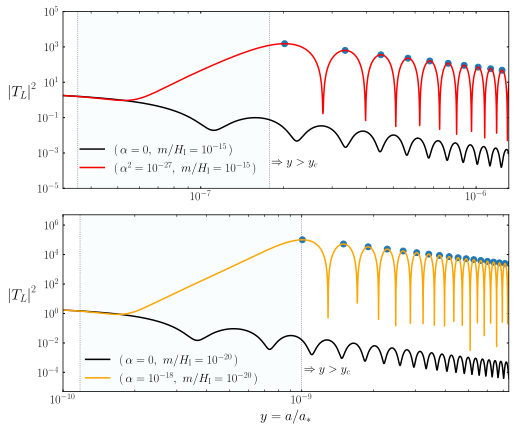

In [44]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex='row', figsize = (8,7))


for i in range(2):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        
ax[0].set_ylim(10**(-5),10**(5))
ax[1].set_ylim(5 * 10**(-6),5* 10**(6))

ax[0].set_xlim(m[y_ind1]**(1/2),y_c1 * np.exp(2))
ax[1].set_xlim(m[y_ind2]**(1/2),y_c2 * np.exp(2))

plt.xlabel(r'$ y = a/a_* $', fontsize=14)

ax[0].set_ylabel(r'$ \Big| T_L \Big|^2 $', fontsize=15, rotation = False,labelpad = 15)
ax[1].set_ylabel(r'$ \Big|T_L\Big|^2 $', fontsize=15, rotation = False,labelpad = 15)

ax[0].text(1.8 * 10 ** (-7), 0.0002, r'$ \Rightarrow y > y_c $', color = 'black', fontsize=12)
ax[1].text(1.02 * 10 ** (-9), 0.0001, r'$ \Rightarrow y > y_c $', color = 'black', fontsize=12)

ax[0].axvspan(yre1,y_c1, alpha = 0.05, color = 'skyblue')


ax[1].axvspan(yre2,y_c2, alpha = 0.05, color = 'skyblue')

ax[0].axvline(y_c1, color = 'gray', linestyle = ':', lw = 0.8)
ax[0].axvline(yre1, color = 'gray', linestyle = ':', lw = 0.8)

ax[1].axvline(y_c2, color = 'gray', linestyle = ':', lw = 0.8)
ax[1].axvline(yre2, color = 'gray', linestyle = ':', lw = 0.8)

ax[0].scatter(yp1,Tlsqp1)
ax[0].plot(ys1, ALsqRDU1, '-k', label = r'$(\,\alpha = 0, \,\, m/H_{\rm I} = 10^{-15}\,)$')
ax[0].plot(ysLin1, ALsqRDULin1, color = 'red', label = r'$(\,\alpha^2 = 10^{-27}, \,\, m/H_{\rm I} = 10^{-15}\,)$')
ax[0].legend(loc = (0.028,0.05), fontsize = 12, frameon = False)

ax[1].scatter(yp2,Tlsqp2)
ax[1].plot(ys2, ALsqRDU2, '-k', label = r'$(\,\alpha = 0, \,\, m/H_{\rm I} = 10^{-20}\,)$')
ax[1].plot(ysLin2, ALsqRDULin2, color = 'orange', label = r'$(\,\alpha = 10^{-18}, \,\, m/H_{\rm I} = 10^{-20}\,)$')
ax[1].legend(loc = (0.04,0.01), fontsize = 12, frameon = False)

plt.subplots_adjust(hspace=0.15, wspace=0.15)
plt.savefig('SSTLsq.pdf', bbox_inches= 'tight', format= 'pdf', dpi=720)

In [45]:
# Take the log of extrema vs y points to fit: ignore the first 5 extrema (oscillations) to obtain a better fit

params1, cov1 = curve_fit(lambda x, *p: p[0] - p[1] * x, np.log(yp1[5:]), np.log(Tlsqp1[5:]), [0,0])
params2, cov2 = curve_fit(lambda x, *p: p[0] - p[1] * x, np.log(yp2[5:]), np.log(Tlsqp2[5:]), [0,0])
    
print(params1,params2)

[-23.29934044   1.99787056] [-29.66102863   1.99740437]


In [46]:
def TLsq1(y): # Fitting function that can extrapolate |T_L|^2 to late time y >> 1
    return np.exp(params1[0])*(y ** (-params1[1]))

def TLsq2(y): # Fitting function that can extrapolate |T_L|^2 to late time y >> 1
    return np.exp(params2[0])*(y ** (-params2[1]))

In [52]:
# A mode becomes non-relativistic at y = xs[xsindex]

print(f'Maximally enhanced mode becomes non-relativistic at very late times: y_nr1 = {xs1[xsindex]:.1e} and y_nr2 = {xs2[xsindex]:.1e}')


Maximally enhanced mode becomes non-relativistic at very late times: y_nr1 = 2.8e+07 and y_nr2 = 8.5e+09


In [62]:
# we need y x_*^2 |T_L|^2 at y_nr to estimate the amplitude of the contribution this mode can have on 
# energy density of the longitudinal modes 

print('Checking the amplitude for both parameter choices:')
print()

print(f'y_nr1 xs1^2 |T_L(y_nr1)|^2 = {xs1[xsindex] * (xs1[xsindex] ** 2) * TLsq1(xs1[xsindex])}')

print(f'y_nr2 xs2^2 |T_L(y_nr2)|^2 = = {xs2[xsindex] * (xs2[xsindex] ** 2) * TLsq2(xs2[xsindex])}')
print()
print('For both parameter choices:')
if xs1[xsindex] * (xs1[xsindex] ** 2) * TLsq1(xs1[xsindex]) and xs2[xsindex] * (xs2[xsindex] ** 2) * TLsq2(xs2[xsindex]) < 0.01:
    print(f'Contribution of the maximally enhanched mode to the power spectrum of the A_L is less than one percent')

print()
print('Repeat the procedure with different parameter choices playing with a_ind and y_ind above!!')

Checking the amplitude for both parameter choices:

y_nr1 xs1^2 |T_L(y_nr1)|^2 = 0.002205516533858235
y_nr2 xs2^2 |T_L(y_nr2)|^2 = = 0.0011822824827223515

For both parameter choices:
Contribution of the maximally enhanched mode to the power spectrum of the A_L is less than one percent

Repeat the procedure with different parameter choices playing with a_ind and y_ind above!!
